In [1]:
import pandas as pd
from bifacial_peak_shaving import *
from utils import *
pd.options.plotting.backend='plotly'

# Data

In [2]:
dir = './Data/'

## Load

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29184 entries, 2018-05-01 00:00:00 to 2019-02-28 23:45:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Load (kW)  29184 non-null  float64
dtypes: float64(1)
memory usage: 456.0 KB
None
          Load (kW)
count  29184.000000
mean      21.240250
std       20.452856
min        0.000000
25%        4.942236
50%       14.632581
75%       33.154909
max      117.733400


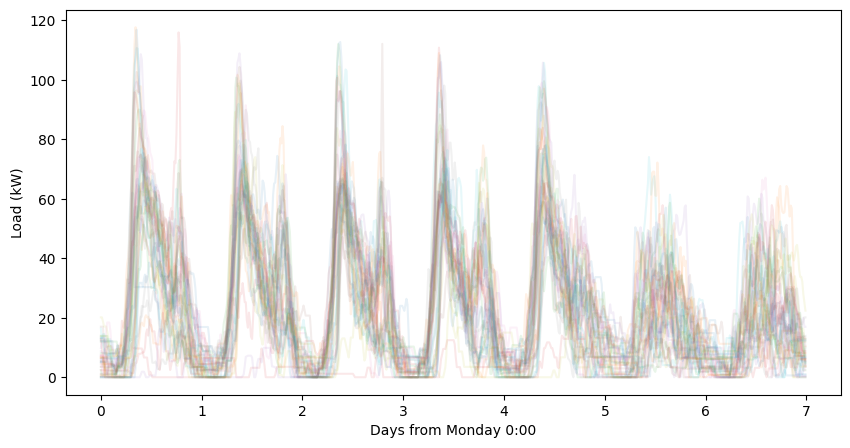

In [3]:
load = pd.read_csv(dir+'acn_caltech.csv',
                   index_col=0,
                   parse_dates=True,
                   comment='#',
                   )
                    #.resample('1h').mean()\
                    #.fillna(method='ffill')
                    #.loc['2018-4-26':'2019-3-22']
#load = pd.DataFrame({'Load (kW)':list(load.loc['2019-1-2 0:00':'2019-1-2 16:00','Load (kW)'])+list(load.loc[:,'Load (kW)'])},
#                     index=pd.date_range('2019-1-1 0:00',periods=8760,freq='1h'))
#load.loc['2019-5-20'] = load.loc['2019-5-22'].values
#load.loc['2019-5-21'] = load.loc['2019-5-22'].values
#load.index = pd.date_range('1901-1-1 0:00',periods=35040,freq='15min')
load = load.fillna(method='ffill')
#interval_min = int(load.index.to_series().diff().mean().seconds/60)
#load = load.resample('30min').mean()
load = load.loc['2018-5-1':'2019-2-28']
print(load.info())
print(load.describe())
plot_weekly(load['Load (kW)'])
load.plot()

## Solar

- 7 kWp, TMY

- Net zero capacity

  - $capacity[kWp] = production[kWh] \times yield [\frac{kWh}{kWp}]^{-1}$

In [4]:
solar_angles = ['s20','w90','s20w90']

dir_solar = dir+'Solar/Modelled/'

s20 = pd.concat((pd.read_csv(dir_solar+'pasadena_2018_15min_367mods_s20.csv',index_col=0,parse_dates=True,comment='#'),
                 pd.read_csv(dir_solar+'pasadena_2019_15min_367mods_s20.csv',index_col=0,parse_dates=True,comment='#')))

w90 = pd.concat((pd.read_csv(dir_solar+'pasadena_2018_15min_367mods_w90.csv',index_col=0,parse_dates=True,comment='#'),
                 pd.read_csv(dir_solar+'pasadena_2019_15min_367mods_w90.csv',index_col=0,parse_dates=True,comment='#')))

s20w90 = pd.concat((pd.read_csv(dir_solar+'pasadena_2018_15min_367mods_s20w90.csv',index_col=0,parse_dates=True,comment='#'),
                    pd.read_csv(dir_solar+'pasadena_2019_15min_367mods_s20w90.csv',index_col=0,parse_dates=True,comment='#')))

solar = pd.concat((s20,w90,s20w90),axis=1)
solar.columns=solar_angles

#solar = solar.resample('1h').mean()

solar = solar.loc[load.index]

net_zero_capacity = load['Load (kW)'].sum() / (solar.s20.sum()) # load=production / yield
solar = solar * net_zero_capacity # scale to net 0

print(solar.info(),'\n')
print(solar.describe())
solar

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29184 entries, 2018-05-01 00:00:00 to 2019-02-28 23:45:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s20     29184 non-null  float64
 1   w90     29184 non-null  float64
 2   s20w90  29184 non-null  float64
dtypes: float64(3)
memory usage: 2.1 MB
None 

                s20           w90        s20w90
count  29184.000000  29184.000000  29184.000000
mean      21.240250     18.335248     19.755800
std       29.506134     24.538184     24.910193
min       -0.068757     -0.057088     -0.065502
25%       -0.008332     -0.008332     -0.008332
50%       -0.008332     -0.008332     -0.008332
75%       45.867719     36.567233     45.166796
max      109.157001     89.395674     81.979275


s20       w90    s20w90
Datetime (PST)                                   
2018-05-01 00:00:00 -0.008332 -0.008332 -0.008332
2018-05-01 00:15:00 -0.008332 -0.008332 -0.008332
2018-05-01 00:30:00 -0.008332 -0.008332 -0.008332
2018-05-01 00:45:00 -0.008332 -0.008332 -0.008332
2018-05-01 01:00:00 -0.008332 -0.008332 -0.008332
...                       ...       ...       ...
2019-02-28 22:45:00 -0.008332 -0.008332 -0.008332
2019-02-28 23:00:00 -0.008332 -0.008332 -0.008332
2019-02-28 23:15:00 -0.008332 -0.008332 -0.008332
2019-02-28 23:30:00 -0.008332 -0.008332 -0.008332
2019-02-28 23:45:00 -0.008332 -0.008332 -0.008332

[29184 rows x 3 columns]

In [5]:
# solar_angles = ['s20','w20','w90','s20w90']
# solar = pd.concat(( 
#                     pd.read_csv(dir+'Solar/Modelled/lemooreCA_7kwp_s20deg.csv',index_col=0),
#                     pd.read_csv(dir+'Solar/Modelled/lemooreCA_7kwp_w20deg.csv',index_col=0),
#                     pd.read_csv(dir+'Solar/Modelled/lemooreCA_7kwp_w90deg.csv',index_col=0),
#                     pd.read_csv(dir+'Solar/Modelled/lemooreCA_3.5kwp_s20deg_3.5kwp_w90deg.csv',index_col=0),
#                    ),
#                   axis=1)
# solar.index = pd.date_range('1900-1-1 0:00',periods=8760,freq='1h')
# solar.columns = solar_angles
# net_zero_capacity = load['Load (kW)'].sum() / (solar.s20.sum()/7) # load=production / yield
# solar = solar * net_zero_capacity/7 # scale to net 0
# solar.describe()

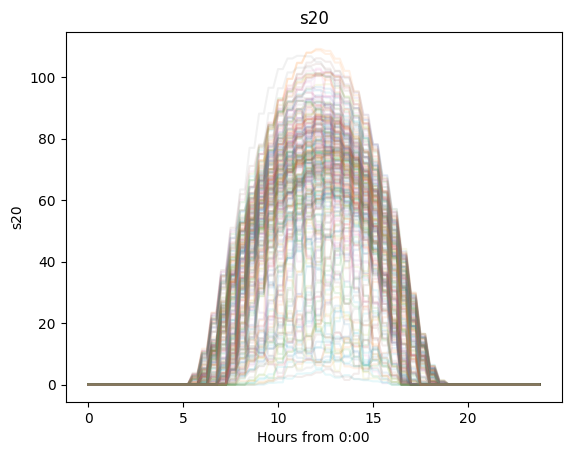

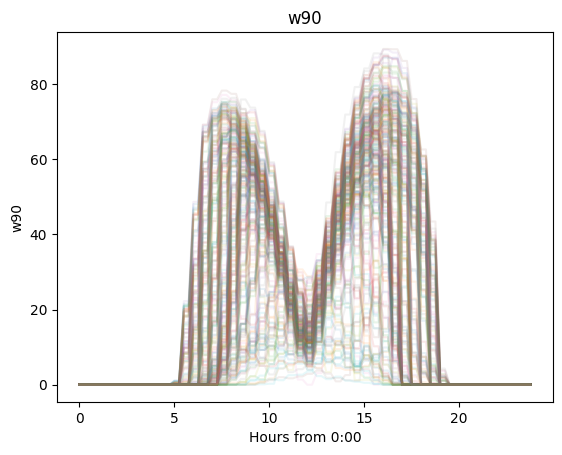

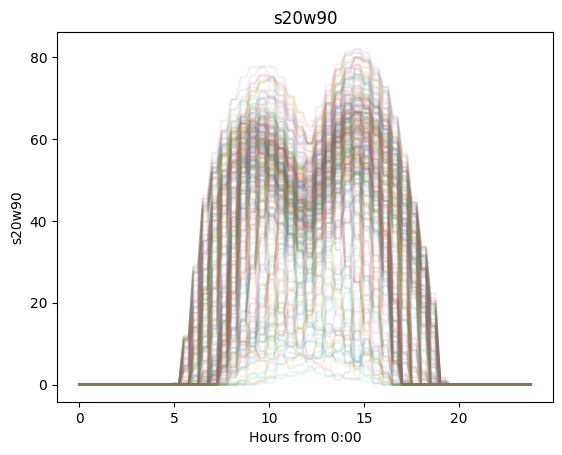

In [6]:
for col in solar:
    plot_daily(solar[col],title=col)#,interval_min=60)

## Net load

In [7]:
solar.index = load.index
df = pd.concat((load,solar),axis=1)
df.columns = ['load'] + ['solar_'+x for x in solar.columns]
for angle in solar.columns:
    df[f'netload_{angle}'] = df['load'] - solar[angle]
df    

load  solar_s20  solar_w90  solar_s20w90  \
Datetime (PST)                                                      
2018-05-01 00:00:00  3.013458  -0.008332  -0.008332     -0.008332   
2018-05-01 00:15:00  3.013458  -0.008332  -0.008332     -0.008332   
2018-05-01 00:30:00  3.013458  -0.008332  -0.008332     -0.008332   
2018-05-01 00:45:00  3.013458  -0.008332  -0.008332     -0.008332   
2018-05-01 01:00:00  3.013458  -0.008332  -0.008332     -0.008332   
...                       ...        ...        ...           ...   
2019-02-28 22:45:00  4.867047  -0.008332  -0.008332     -0.008332   
2019-02-28 23:00:00  4.867047  -0.008332  -0.008332     -0.008332   
2019-02-28 23:15:00  4.867047  -0.008332  -0.008332     -0.008332   
2019-02-28 23:30:00  4.867047  -0.008332  -0.008332     -0.008332   
2019-02-28 23:45:00  4.867047  -0.008332  -0.008332     -0.008332   

                     netload_s20  netload_w90  netload_s20w90  
Datetime (PST)                                                 
2018-05-01 00:00:00     3.021790     3.021790        3.021790  
2018-05-01 00:15:00     3.021790     3.021790        3.021790  
2018-05-01 00:30:00     3.021790     3.021790        3.021790  
2018-05-01 00:45:00     3.021790     3.021790        3.021790  
2018-05-01 01:00:00     3.021790     3.021790        3.021790  
...                          ...          ...             ...  
2019-02-28 22:45:00     4.875379     4.875379        4.875379  
2019-02-28 23:00:00     4.875379     4.875379        4.875379  
2019-02-28 23:15:00     4.875379     4.875379        4.875379  
2019-02-28 23:30:00     4.875379     4.875379        4.875379  
2019-02-28 23:45:00     4.875379     4.875379        4.875379  

[29184 rows x 7 columns]

load v s20

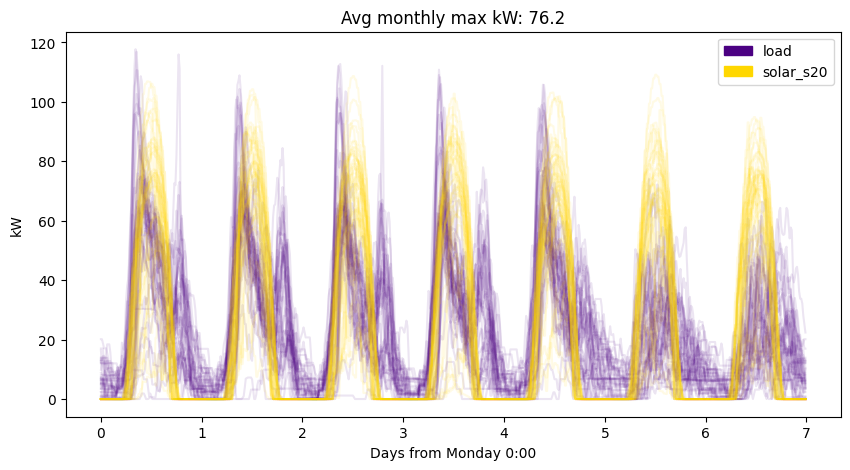

In [8]:
l = df['load']
s = df['solar_s20']
avg_monthly_max = (l - s).resample('1M').max().mean()  
plot_weekly((l,s),f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

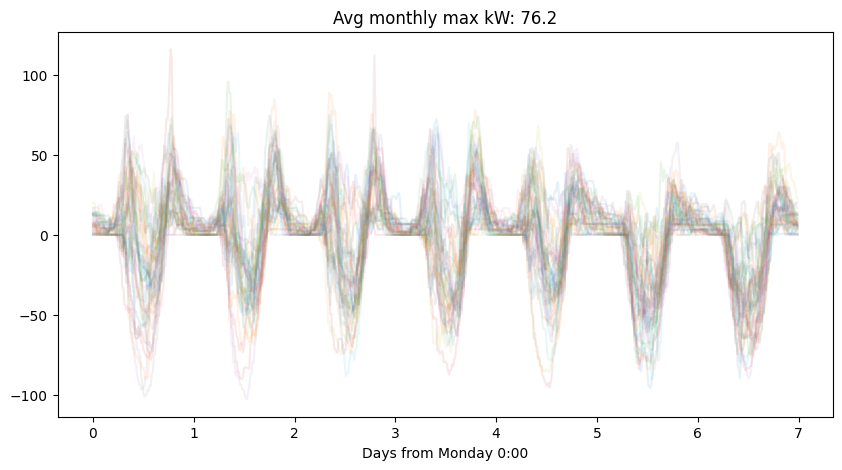

In [9]:
l = df['load']
s = df['solar_s20']
avg_monthly_max = (l - s).resample('1M').max().mean()  
plot_weekly(l-s,f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

load v w20

In [10]:
# l = df['load']
# s = df['solar_w20']
# avg_monthly_max = (l - s).resample('1M').max().mean()  
# plot_weekly((l,s),f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

In [11]:
# l = df['load']
# s = df['solar_w20']
# avg_monthly_max = (l - s).resample('1M').max().mean()  
# plot_weekly(l-s,f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

load v w90

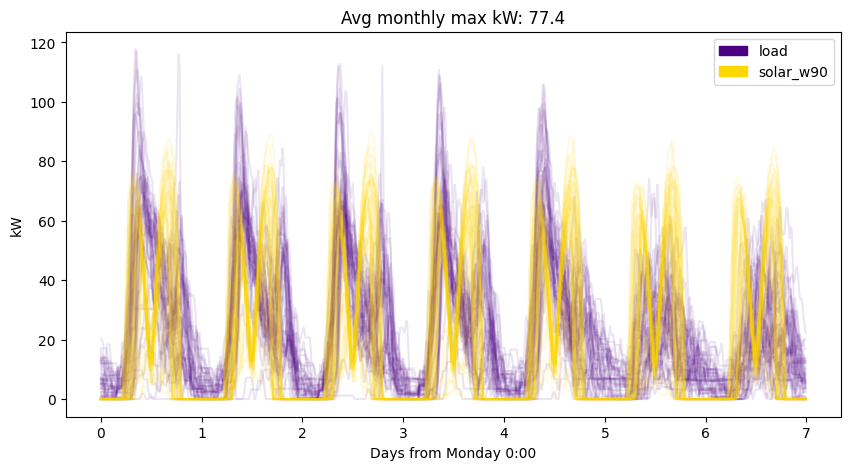

In [12]:
l = df['load']
s = df['solar_w90']
avg_monthly_max = (l - s).resample('1M').max().mean()  
plot_weekly((l,s),f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

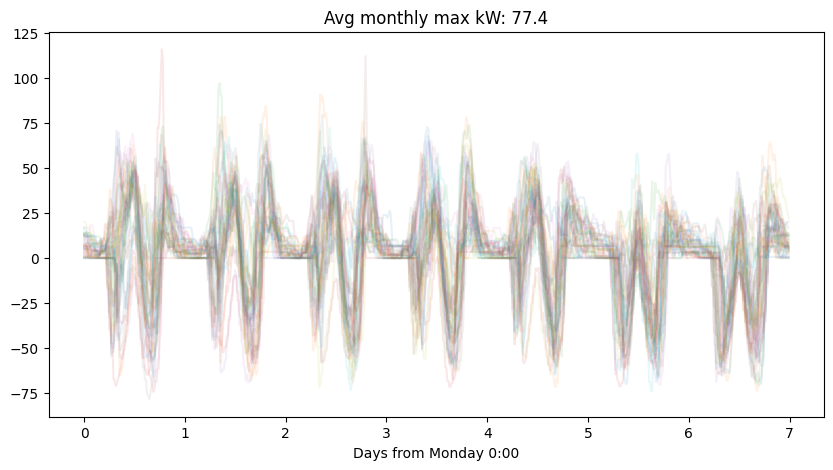

In [13]:
l = df['load']
s = df['solar_w90']
avg_monthly_max = (l - s).resample('1M').max().mean()  
plot_weekly(l-s,f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

load v s20w90

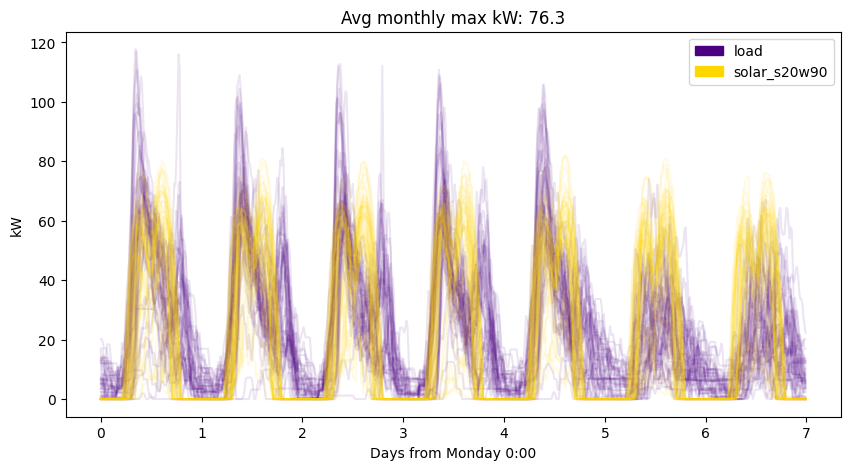

In [14]:
l = df['load']
s = df['solar_s20w90']
avg_monthly_max = (l - s).resample('1M').max().mean()  
plot_weekly((l,s),f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

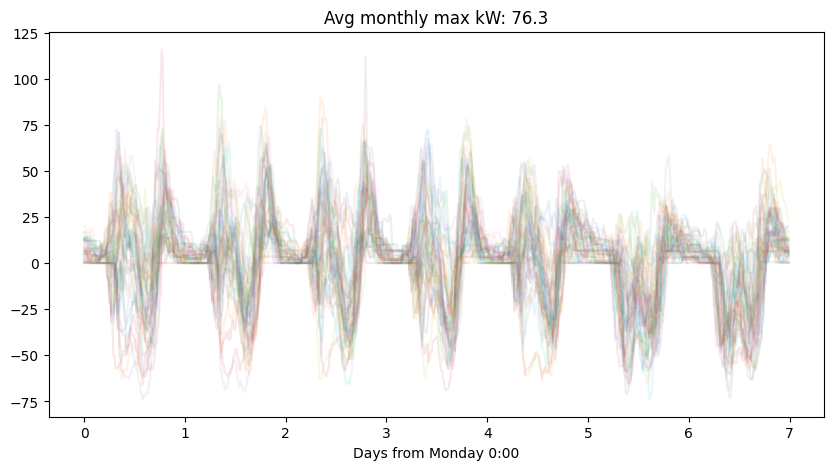

In [15]:
l = df['load']
s = df['solar_s20w90']
avg_monthly_max = (l - s).resample('1M').max().mean()  
plot_weekly(l-s,f'Avg monthly max kW: {avg_monthly_max:.1f}',ylabel='kW')

# Baseline costs

Load only, and net load given various solar

In [16]:
TOU = [{'price':26.07,      'hours':list(range(24)) },
       {'price': 6.81,      'hours':list(range(14,16))+list(range(21,23))},
       {'price':32.90,      'hours':list(range(16,21))}]

In [17]:
all_cost = {}

cost = 0
for year in df.index.year.unique():
    df_year = df[df.index.year==year]
    for month in df_year.index.month.unique():
        df_month = df_year[df_year.index.month==month]
        cost += calc_power_cost(df_month['load'],TOU)
        all_cost['load'] = round(cost,0)

for angle in solar_angles:
    cost = 0
    for year in df.index.year.unique():
        df_year = df[df.index.year==year]
        for month in df_year.index.month.unique():
            df_month = df_year[df_year.index.month==month]
            cost += calc_power_cost(df_month[f'netload_{angle}'],TOU)
    all_cost[angle] = round(cost,0)
all_cost

{'load': 44467.0, 's20': 36758.0, 'w90': 37090.0, 's20w90': 36832.0}

# Monthly peaks

## Single TOU

In [18]:
peak_begin,peak_end = 8,11
angle = 's20'
peaks = calc_monthly_peaks(df[f'netload_{angle}'],peak_begin,peak_end)

# angle = 'w20'
# peaks = pd.concat((peaks,calc_monthly_peaks(df[f'netload_{angle}'],peak_begin,peak_end)),axis=1)
# peaks[f'netload_s20->{angle} reduc kw'] = peaks['netload_s20 kw'] - peaks[f'netload_{angle} kw']

angle = 'w90'
peaks = pd.concat((peaks,calc_monthly_peaks(df[f'netload_{angle}'],peak_begin,peak_end)),axis=1)
peaks[f'netload_s20->{angle} reduc kw'] = peaks['netload_s20 kw'] - peaks[f'netload_{angle} kw']

angle = 's20w90'
peaks = pd.concat((peaks,calc_monthly_peaks(df[f'netload_{angle}'],peak_begin,peak_end)),axis=1)
peaks[f'netload_s20->{angle} reduc kw'] = peaks['netload_s20 kw'] - peaks[f'netload_{angle} kw']

#print('Avg w20 reduction',peaks['netload_s20->w20 reduc kw'].mean())
print('Avg w90 reduction',peaks['netload_s20->w90 reduc kw'].mean())
print('Avg s20w90 reduction',peaks['netload_s20->s20w90 reduc kw'].mean())
peaks

Avg w90 reduction -0.25999999999999873
Avg s20w90 reduction 0.03999999999999915


netload_s20 kw       netload_s20 t  netload_w90 kw       netload_w90 t  \
0            52.5 2018-05-11 08:00:00            54.2 2018-05-22 09:00:00   
1            40.8 2018-06-06 08:00:00            43.8 2018-06-06 08:00:00   
2            59.9 2018-07-06 10:00:00            44.5 2018-07-06 10:00:00   
3            51.1 2018-08-20 08:00:00            53.0 2018-08-27 08:00:00   
4            69.8 2018-09-05 08:00:00            71.6 2018-09-05 08:00:00   
5            91.3 2018-10-09 08:00:00            93.0 2018-10-09 08:00:00   
6            58.7 2018-11-08 09:00:00            63.0 2018-11-28 10:00:00   
7            67.4 2018-12-06 09:00:00            67.6 2018-12-06 09:00:00   
8            60.6 2019-01-17 10:00:00            61.7 2019-01-17 10:00:00   
9            59.0 2019-02-14 10:00:00            61.3 2019-02-05 10:00:00   

   netload_s20->w90 reduc kw  netload_s20w90 kw    netload_s20w90 t  \
0                       -1.7               53.0 2018-05-11 08:00:00   
1                       -3.0               42.3 2018-06-06 08:00:00   
2                       15.4               52.2 2018-07-06 10:00:00   
3                       -1.9               51.9 2018-08-20 08:00:00   
4                       -1.8               70.7 2018-09-05 08:00:00   
5                       -1.7               92.2 2018-10-09 08:00:00   
6                       -4.3               60.2 2018-11-08 09:00:00   
7                       -0.2               67.5 2018-12-06 09:00:00   
8                       -1.1               61.2 2019-01-17 10:00:00   
9                       -2.3               59.5 2019-02-05 10:00:00   

   netload_s20->s20w90 reduc kw  
0                          -0.5  
1                          -1.5  
2                           7.7  
3                          -0.8  
4                          -0.9  
5                          -0.9  
6                          -1.5  
7                          -0.1  
8                          -0.6  
9                          -0.5

## Variable TOU

w20

In [19]:
# angle1 = 's20'
# angle2 = 'w20'

# peak_reduc_v_TOU = net_load_peak_reduction_variable_TOU(df,angle1,angle2)
# peak_reduc_v_TOU[peak_reduc_v_TOU['avg peak reduction [kW]']>0.1]

w90

In [20]:
angle1 = 's20'
angle2 = 'w90'

peak_reduc_v_TOU = net_load_peak_reduction_variable_TOU(df,angle1,angle2)
peak_reduc_v_TOU[peak_reduc_v_TOU['avg peak reduction [kW]']>5]

TOU begin [h]  TOU end [h]  max peak reduction [kW]  \
59             14           18                     27.7   
60             14           19                     28.2   
64             15           18                     30.8   
65             15           19                     28.2   
68             16           18                     30.8   
69             16           19                     37.4   
72             17           19                     38.1   

    avg peak reduction [kW]  min peak reduction [kW]  
59                      5.5                     -2.7  
60                      5.9                     -2.3  
64                      6.4                     -1.6  
65                      6.4                     -1.1  
68                      8.5                     -1.1  
69                      7.5                     -1.1  
72                      7.4                     -0.3

s20w90

In [21]:
angle1 = 's20'
angle2 = 's20w90'

peak_reduc_v_TOU = net_load_peak_reduction_variable_TOU(df,angle1,angle2)
peak_reduc_v_TOU[peak_reduc_v_TOU['avg peak reduction [kW]']>5]

TOU begin [h]  TOU end [h]  max peak reduction [kW]  \
68             16           18                     19.2   

    avg peak reduction [kW]  min peak reduction [kW]  
68                      6.0                     -0.6

Best for w90

In [22]:
#df.loc['2022-6-28':'2022-6-30'][['load','solar_s20','solar_w90','solar_s20w90']].plot()

In [23]:
#df.loc['2022-3-5':'2022-3-7'][['load','solar_s20','solar_w90','solar_s20w90']].plot()

Largest spread w90 v s20w90

In [24]:
#df.loc['2022-10-12':'2022-10-14'][['load','solar_s20','solar_w90','solar_s20w90']].plot()

# Peak shaving

In [51]:
angle = 's20'
thresholds = (21.563, 21, 0.0)#(21.563, 21.563, 0.0)
batt_kwh = 100
TOU = [{'price':26.07,      'hours':list(range(24)) },
       {'price':6.81,      'hours':list(range(14,16))+list(range(18,23))},
       {'price':32.90,      'hours':list(range(16,18))}]

fail,dispatch = peak_shaving_sim(  df[['load',f'solar_{angle}',f'netload_{angle}']].loc['2018-6'],
                                          f'netload_{angle}',
                                          batt_kwh,
                                          thresholds,
                                          TOU,
                                          utility_chg_max=batt_kwh,)

cost = calc_power_cost(dispatch.utility,TOU)

plotly_stacked( dispatch.drop(columns=['soc']),
                solar=f'solar_{angle}',
                threshold0=thresholds[0], threshold0_h=TOU[0]['hours'],                     
                threshold1=thresholds[1], threshold1_h=TOU[1]['hours'],
                threshold2=thresholds[2], threshold2_h=TOU[2]['hours'],                                
                title=f'Cost {cost:.1f} ' + {True:'SOE Failure',False:''}[fail],
                size=(800,400),
                #upsample_min=1,
                )

In [49]:
angle = 'w90'
thresholds = (13.044, 13.044, 0.0)
batt_kwh = 100
TOU = [{'price':26.07,      'hours':list(range(24)) },
       {'price':6.81,      'hours':list(range(14,16))+list(range(18,23))},
       {'price':32.90,      'hours':list(range(16,18))}]

fail,dispatch = peak_shaving_sim(  df[['load',f'solar_{angle}',f'netload_{angle}']].loc['2018-6'],
                                          f'netload_{angle}',
                                          batt_kwh,
                                          thresholds,
                                          TOU,
                                          utility_chg_max=batt_kwh,)

cost = calc_power_cost(dispatch.utility,TOU)

plotly_stacked( dispatch.drop(columns=['soc']),
                solar=f'solar_{angle}',
                threshold0=thresholds[0], threshold0_h=TOU[0]['hours'],                     
                threshold1=thresholds[1], threshold1_h=TOU[1]['hours'],
                threshold2=thresholds[2], threshold2_h=TOU[2]['hours'],                                
                title=f'Cost {cost:.1f} ' + {True:'SOE Failure',False:''}[fail],
                size=(800,400),
                #upsample_min=1,
                )

## Minimize cost

Grid search rough, fine, and gradient descent

In [1]:
import numpy as np

TOU = [{'price':26.07,      'hours':list(range(24)) },
       {'price': 6.81,      'hours':list(range(14,16))+list(range(21,23))},
       {'price':32.90,      'hours':list(range(16,21))}]

def f(thresholds):
    th0,th1,th2 = thresholds
    fail,dispatch = peak_shaving_sim(   df_month,
                                    f'netload_{angle}',
                                    batt_kwh,
                                    [th0,th1,th2],
                                    TOU,
                                    utility_chg_max=batt_kwh,)                
    cost = calc_power_cost(dispatch.utility,TOU)
    return cost,fail,dispatch

def grad_f(th_i):
    #c,fail,_ = f(th_i)
    
    d = 0.05
    
    c0_0,fail,_ = f([x+dx for x,dx in zip(th_i,[-d,0,0])])
    if fail == True: c0_0,fail,_ = f(th_i)
    c0_1,fail,_ = f([x+dx for x,dx in zip(th_i,[d,0,0])])
    if fail == True: c0_1,fail,_ = f(th_i)
    
    
    c1_0,fail,_ = f([x+dx for x,dx in zip(th_i,[0,-d,0])])
    if fail == True: c1_0,fail,_ = f(th_i)
    c1_1,fail,_ = f([x+dx for x,dx in zip(th_i,[0,d,0])])
    if fail == True: c1_1,fail,_ = f(th_i)
    
    
    c2_0,fail,_ = f([x+dx for x,dx in zip(th_i,[0,0,-d])])
    if fail == True: c2_0,fail,_ = f(th_i)
    c2_1,fail,_ = f([x+dx for x,dx in zip(th_i,[0,0,d])])
    if fail == True: c2_1,fail,_ = f(th_i)

    
    return (c0_0-c0_1,c1_0-c1_1,c2_0-c2_1)

TOU = [{'price':26.07,      'hours':list(range(24)) },
       {'price': 6.81,      'hours':list(range(14,16))+list(range(21,23))},
       {'price':32.90,      'hours':list(range(16,21))}]

rough_search_max = 100
rough_step = 10

tic = pd.Timestamp.now()

output_filename = 'Output/caltech_ev_mjw6__output__'+tic.strftime('%y-%m-%d_%H-%M-%S')+'.csv'
output = pd.DataFrame([],columns=['angle','batt kwh','total cost']+[f'{y}-{m}' for y,m in zip(df.resample('1m').mean().index.year,df.resample('1m').mean().index.month)])
for angle in ['s20','w90']:#'s20, w20','w90','s20w90'
    for batt_kwh in [50,200,400,600,800,1000,4000]:
        best_monthly = pd.DataFrame([],columns=['year-month','threshold0','threshold1','threshold2','cost'])
        for year in df.index.year.unique():
            df_year = df[df.index.year==year]
            for month in df_year.index.month.unique():
                print(f'{pd.Timestamp.now()} Angle {angle} batt_kwh {batt_kwh } begin new month {year}-{month}')
                df_month = df_year[df_year.index.month==month][['load',f'solar_{angle}',f'netload_{angle}']]
                r = pd.DataFrame([], columns=['i','fail','th0','th1','th2','c','deltac','dc'])
                
                #
                # Rough grid search
                #
                
                k = 0
                for th0 in range(0,rough_search_max,rough_step):
                    for th1 in range(0,rough_search_max,rough_step):
                        th1 = min(th0,th1)
                        for th2 in range(0,rough_search_max,rough_step):
                            k += 1
                            fail,dispatch = peak_shaving_sim(   df_month,
                                                                f'netload_{angle}',
                                                                batt_kwh,
                                                                [th0,th1,th2],
                                                                TOU,
                                                                utility_chg_max=batt_kwh,)                
                            #if fail == False:
                            cost = calc_power_cost(dispatch.utility,TOU)
                            r.loc[len(r)] = [k,fail,th0,th1,th2,cost,pd.NA,pd.NA]
                
                if len(r) > 0:
                    best_cost = r[r.fail==False]['c'].min()
                    imin = r[r.fail==False]['c'].idxmin()
                    best_th0 = r.loc[imin].th0
                    best_th1 = r.loc[imin].th1
                    best_th2 = r.loc[imin].th2
                else: 
                    print(f'\n\n\n /// No viable solutions angle {angle} batt_kwh {batt_kwh} year-month {year}-{month} rough_search_max {rough_search_max}/// \n\n\n')
                    break
                
                print(f'{pd.Timestamp.now()} Rough grid search done for {year}-{month} thresholds=({best_th0:.1f},{best_th1:.1f},{best_th2:.1f}), cost={best_cost:.1f} ')


                #
                # Fine grid search
                #

                for th0 in range(max(0,int(best_th0-rough_step)),int(best_th0+rough_step)):
                    for th1 in range(max(0,int(best_th1-rough_step)),int(best_th1+rough_step)):
                        th1 = min(th0,th1)
                        for th2 in range(max(0,int(best_th2-rough_step)),int(best_th2+rough_step)):                        
                            k += 1
                            fail,dispatch = peak_shaving_sim(   df_month,
                                                                f'netload_{angle}',
                                                                batt_kwh,
                                                                [th0,th1,th2],
                                                                TOU,
                                                                utility_chg_max=batt_kwh,)                
                            #if fail == False:
                            cost = calc_power_cost(dispatch.utility,TOU)
                            r.loc[len(r)] = [k,fail,th0,th1,th2,cost,pd.NA,pd.NA]
                
                best_cost = r[r.fail==False]['c'].min()
                imin = r[r.fail==False]['c'].idxmin()
                best_th0 = r.loc[imin].th0
                best_th1 = r.loc[imin].th1
                best_th2 = r.loc[imin].th2
                
                print(f'{pd.Timestamp.now()} Fine grid search done for {year}-{month} thresholds=({best_th0:.1f},{best_th1:.1f},{best_th2:.1f}), cost={best_cost:.1f} ')
                
                #
                # Gradient descent large LR
                #                

                LR = (0.1,0.1,0.1)
                
                c = []
                th = [[best_th0,best_th1,best_th2]]
                cost,fail,dispatch = f(th[0])
                c.append(cost)
                
                final_countdown = 20
                for i in range(1,500):
                    dc = grad_f(th[i-1])
                    dth = [(dx+nz)*lr for dx,lr,nz in zip(dc,LR,np.random.rand(3))]
                    new_th = [max(0,x+dx) for x,dx in zip(th[i-1],dth)]
                    new_th[1] = max(new_th[0],new_th[1]) # th1 <= th0
                    th.append(new_th)
                    cost,fail,dispatch = f(th[i])                    
                    c.append(cost)
                    
                    r.loc[len(r)] = [i+k,
                                    fail,
                                    round(th[i][0],3),
                                    round(th[i][1],3),
                                    round(th[i][2],3),
                                    c[i],
                                    c[i]-c[i-1],
                                    [round(x,3) for x in dc]]
                    

                    # stopping conditions
                    
                    if r[['deltac']][k:].dropna().rolling(100).std().iloc[-1,0] > 10:
                        break
                    
                    # deltac = r[['deltac']].rolling(100).mean()[k:].dropna()
                    # if len(deltac[deltac.deltac > -0.1]) >= 50:
                    #     break
                    
                    # if abs(c[i]-c[i-1])<0.3:
                    #     final_countdown -= 1
                        
                    # if final_countdown == 0:
                    #     break
                                    
                    
                #
                # Gradient descent small LR
                #                
                
                # LR = (0.01,0.01,0.01)
                
                # print(f'{pd.Timestamp.now()} Gradient descent decrease LR to {LR} for {year}-{month} thresholds=({best_th0:.1f},{best_th1:.1f},{best_th2:.1f}), cost={best_cost:.1f} ')
                
                # j = i
                # for i in range(j,j+500):
                #     dc = grad_f(th[i-1])
                #     dth = [(dx+nz)*lr for dx,lr,nz in zip(dc,LR,rnd.rand(3))]
                #     new_th = [max(0,x+dx) for x,dx in zip(th[i-1],dth)]
                #     th.append(new_th)
                #     cost,fail,dispatch = f(th[i])                    
                #     c.append(cost)
                    
                #     r.loc[len(r)] = [i+k,
                #                      fail,
                #                      round(th[i][0],3),
                #                      round(th[i][1],3),
                #                      round(th[i][2],3),
                #                      c[i],
                #                      c[i]-c[i-1],
                #                      [round(x,3) for x in dc]]


                best_cost = r[r.fail==False]['c'].min()
                imin = r[r.fail==False]['c'].idxmin()
                best_th0 = r.loc[imin].th0
                best_th1 = r.loc[imin].th1
                best_th2 = r.loc[imin].th2
                best_monthly.loc[len(best_monthly)] = [f'{year}-{month}',
                                                    best_th0,
                                                    best_th1,
                                                    best_th2,
                                                    best_cost]
            
                print(f'{pd.Timestamp.now()} Gradient descent done for {year}-{month} thresholds=({best_th0:.1f},{best_th1:.1f},{best_th2:.1f}), cost={best_cost:.1f} ')
        
        #best_monthly.index = best_monthly.month
        #best_monthly = best_monthly.drop(columns=['month'])
        
        # print('/// Best monthly')
        # print(f'Batt kwh {batt_kwh}')
        # print(f'Total cost {best_monthly.cost.sum():.1f}')
        # print(best_monthly.T,'\n\n')
        
        
        new_row = [angle, batt_kwh, best_monthly.cost.sum()]
        for th0,th1,th2 in zip(best_monthly.threshold0,best_monthly.threshold1,best_monthly.threshold2):
            new_row.append( (th0,th1,th2) )
        output.loc[len(output)] = new_row
        output.to_csv(output_filename)
        
# r.loc[r.fail==False,'c'] = r[r.fail==False].c
# r.loc[r.fail==True,'c (fail)'] = r[r.fail==True].c
# r[['c','c (fail)']].plot()
print('Elapsed',pd.Timestamp.now()-tic)

NameError: name 'pd' is not defined

In [ ]:
output = pd.read_csv(output_filename,
                     index_col=0)
reduc = {}
for angle in ['w90']:
    reduc[angle] = (1 - output[output.angle==angle]['total cost'].values\
                                    /output[output.angle=='s20']['total cost'].values)\
                                        .round(3)

print(pd.DataFrame(reduc))

In [28]:
r[['deltac']][k:].dropna().rolling(100).std().plot()

In [29]:
r[r.fail==False].loc[k+1:].plot.scatter(x='th0',y='c',color='i',width=800,height=400)

In [30]:
r[r.fail==False].loc[k+1:].plot.scatter(x='th1',y='c',color='i',width=800,height=400)

In [31]:
r[r.fail==False].loc[k+1:].plot.scatter(x='th2',y='c',color='i',width=800,height=400)

In [32]:
r.loc[k+1:][['th0','th1','c']].plot.scatter(x='th0',y='th1',color='c')

In [33]:
r.loc[k+1:][['th0','th2','c']].plot.scatter(x='th0',y='th2',color='c')

In [34]:
import plotly.express as px

fig = px.scatter_3d(r.loc[k+1:], x='th0', y='th1', z='th2',
              color='c')
fig.show()